In [ ]:
import os, cv2, keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [ ]:
!unzip Airplanes_Annotations.zip
!unzip Images.zip

Archive:  Airplanes_Annotations.zip
   creating: Airplanes_Annotations/
 extracting: Airplanes_Annotations/airplane_095.csv  
  inflating: Airplanes_Annotations/airplane_094.csv  
  inflating: Airplanes_Annotations/airplane_093.csv  
  inflating: Airplanes_Annotations/airplane_092.csv  
  inflating: Airplanes_Annotations/airplane_091.csv  
  inflating: Airplanes_Annotations/airplane_090.csv  
 extracting: Airplanes_Annotations/airplane_089.csv  
 extracting: Airplanes_Annotations/airplane_088.csv  
 extracting: Airplanes_Annotations/airplane_087.csv  
 extracting: Airplanes_Annotations/airplane_086.csv  
  inflating: Airplanes_Annotations/airplane_085.csv  
 extracting: Airplanes_Annotations/airplane_084.csv  
  inflating: Airplanes_Annotations/airplane_083.csv  
  inflating: Airplanes_Annotations/airplane_082.csv  
 extracting: Airplanes_Annotations/airplane_081.csv  
 extracting: Airplanes_Annotations/airplane_080.csv  
 extracting: Airplanes_Annotations/airplane_079.csv  
  inflatin

Посмотрим, что из себя представляют исходные данные. Фотографии — снимки самолетов в аэропортах. Каждый снимок снабжен аннотацией-разметкой: в соответсвующем csv файле указаны координаты вершин прямоугольника, в котором находится самолет.

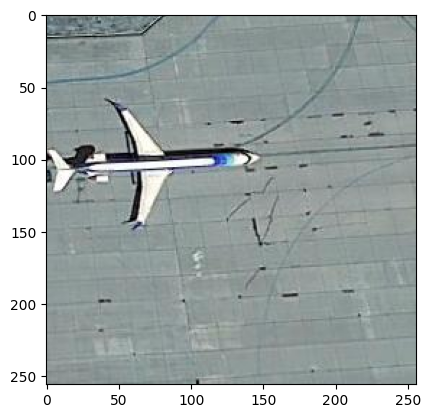

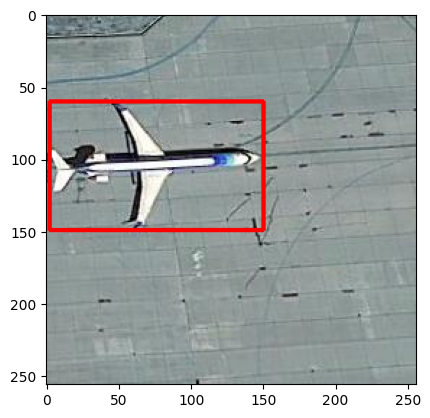

In [ ]:
filename = 'airplane_003.jpg'
img = cv2.imread('Images/' + filename)
df = pd.read_csv('Airplanes_Annotations/' + 'airplane_003.csv')
plt.imshow(img)
for row in df.iterrows():
  x1 = int(row[1][0].split(" ")[0])
  y1 = int(row[1][0].split(" ")[1])
  x2 = int(row[1][0].split(" ")[2])
  y2 = int(row[1][0].split(" ")[3])
  cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
plt.figure()
plt.imshow(img)

Конечно, для тренировки модели неплохо бы фон отделить от непосредственно самолетов, да и получить побольше различных тренировочных данных. На первом этапе именно этим и займемся.

In [ ]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

Воспользуемся алгоритмом селективного поиска. Сам алгоритм базируется на графах и методе иерархической группировки похожих участков на снимке. Похожесть включает в себя соответствия по цвету, текстуре, размеру или форме. В графовом представлении вершиной является интенсивность текущего пикселя, ребра соединяют пару соседних пикселей. Вес ребра — это модуль разности интенсивностей пикселей вершин. С помощью графа выделяются фрагменты, которые затем группируются, согласно следующему принципу: ребра между двумя вершинами в одной группе должны иметь меньшие веса, а ребра между двумя вершинами в разных группах должны иметь больший вес. После того, как два наиболее похожих участка сгруппированы, между полученным участком и его соседями вычисляется новое сходство. Процесс группировки наиболее похожих областей повторяется до тех пор, пока все изображение не станет одной областью. В итоге, алгоритм селективного поиска реализуется с помощью детальной сегментации изображения в зависимости от интенсивности пикселей, с использованием метода сегментации на основе графов и выборочного поиска.

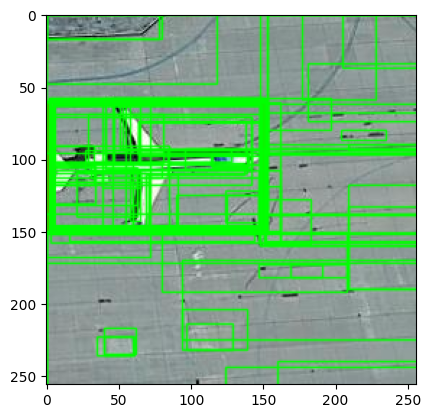

In [ ]:
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
rects = ss.process()
img_out = img.copy()
for i, rect in (enumerate(rects)):
  if i < 100:
    x, y, w, h = rect
    cv2.rectangle(img_out, (x, y), (x + w, y + h), (0, 255, 0), 1, cv2.LINE_AA)
plt.imshow(img_out)

Реализуем IoU для вычисления меры сходства.

In [ ]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

Теперь получим тренировочную выборку

In [ ]:
train_images=[]
train_labels=[]
for e, i in enumerate(os.listdir('Airplanes_Annotations/')):
    try:
        if i.startswith("airplane"): # Обучаться будем только на картинках, название которых содержит airplane (700 штук)
            filename = i.split(".")[0]+".jpg"
            print(filename)
            image = cv2.imread('Images/' + filename)
            df = pd.read_csv('Airplanes_Annotations/' + i)
            coordinates = []
            for row in df.iterrows(): # Парсим координаты
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                coordinates.append({"x1": x1,"x2": x2,"y1": y1,"y2": y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            true_counter = 0
            false_counter = 0
            flag = 0
            true_flag = 0
            false_flag = 0
            for e, result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for coord in coordinates:
                        x, y, w, h = result # Получаем координаты прямоугольника
                        iou = get_iou(coord,{"x1": x,"x2": x + w,"y1": y,"y2": y + h}) # Сравниваем
                        if true_counter < 30: # С каждой картинки берем не более 30 положительных примеров
                            if iou > 0.8: # Считаем пример положительным, если мера больше, чем ...
                                timage = imout[y: y + h, x: x + w]
                                resized = cv2.resize(timage, (224, 224), interpolation = cv2.INTER_AREA) # все картинки делаем одинаковыми
                                train_images.append(resized)
                                train_labels.append(1)
                                true_counter += 1
                        else :
                            true_flag = 1 # Набрали достаточное количество положительных примеров
                        if false_counter < 30: # С каждой картинки берем не более 30 отрицательных примеров
                            if iou < 0.2: # Считаем пример отрицательным, если мера меньше, чем ...
                                timage = imout[y: y + h, x: x + w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA) # все картинки делаем одинаковыми
                                train_images.append(resized)
                                train_labels.append(0)
                                false_counter += 1
                        else :
                            false_flag = 1 # Набрали достаточное количество отрицательных примеров
                    if true_flag == 1 and false_flag == 1:
                        print("Nice picture") # Если набрали 30 положительных и 30 отрицательных примеров с одной картинки — заканчиваем
                        flag = 1
    except Exception as e:
        print(e)
        print("error in " + filename)
        continue

airplane_157.jpg
airplane_213.jpg
airplane_567.jpg
airplane_500.jpg
airplane_306.jpg
airplane_381.jpg
airplane_204.jpg
airplane_064.jpg
airplane_545.jpg
airplane_577.jpg
airplane_487.jpg
airplane_320.jpg
airplane_551.jpg
airplane_660.jpg
airplane_479.jpg
airplane_226.jpg
airplane_593.jpg
airplane_375.jpg
airplane_068.jpg
airplane_222.jpg
airplane_167.jpg
airplane_679.jpg
airplane_696.jpg
airplane_531.jpg
airplane_169.jpg
airplane_657.jpg
airplane_615.jpg
airplane_195.jpg
airplane_246.jpg
airplane_602.jpg
airplane_634.jpg
airplane_024.jpg
airplane_181.jpg
airplane_585.jpg
airplane_329.jpg
airplane_637.jpg
airplane_327.jpg
airplane_249.jpg
airplane_199.jpg
airplane_643.jpg
airplane_297.jpg
airplane_686.jpg
airplane_038.jpg
airplane_243.jpg
airplane_154.jpg
airplane_134.jpg
airplane_311.jpg
airplane_244.jpg
airplane_666.jpg
airplane_682.jpg
airplane_002.jpg
airplane_481.jpg
airplane_252.jpg
airplane_250.jpg
airplane_214.jpg
airplane_173.jpg
airplane_398.jpg
airplane_495.jpg
airplane_265.j

Получили тренировочный набор данных. Положительных примеров где-то 1/3

(25137, 224, 224, 3)


4197

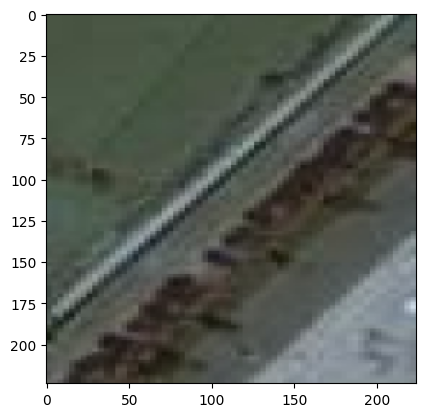

In [ ]:
X_new = np.array(train_images)
y_new = np.array(train_labels)
print(X_new.shape)
plt.imshow(X_new[0])
y_new[0]
np.count_nonzero(y_new)

Подключим CNN VGG16

In [ ]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
vggmodel = VGG16(weights = 'imagenet', include_top = True)

553467096/553467096 [==============================] - 16s 0us/step


Можно посомтреть на ее архитектуру

In [ ]:
for layers in (vggmodel.layers):
    print(layers)

Заморозим первые 15 слоев. Настроим распознавание двух классов. Посмотрим на итоговую обучаемую модель.

In [ ]:
for layers in (vggmodel.layers)[:15]:
    layers.trainable = False
X = vggmodel.layers[-2].output
predictions = Dense(2, activation = "softmax")(X)
model_final = Model(inputs = vggmodel.input, outputs = predictions)
opt = Adam(lr = 0.0001)
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])
model_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


                                                                 
 block5_conv3 (Conv2D)       (None, 14, 14, 512)       2359808   
                                                                 
 block5_pool (MaxPooling2D)  (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 fc1 (Dense)                 (None, 4096)              102764544 
                                                                 
 fc2 (Dense)                 (None, 4096)              16781312  
                                                                 
 dense (Dense)               (None, 2)                 8194      
                                                                 
Total params: 134,268,738
Trainable params: 126,633,474
Non-trainable params: 7,635,264
______________________________________________________

Подготовим тренировочный и тестовый наборы данных

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1 - Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold = None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)
lenc = MyLabelBinarizer()
Y = lenc.fit_transform(y_new)
X_train, X_test, y_train, y_test = train_test_split(X_new, Y, test_size = 0.15)

Проведем аугментацию данных перед обучением

In [ ]:
trdata = ImageDataGenerator(horizontal_flip = True, vertical_flip = True, rotation_range = 90)
traindata = trdata.flow(x = X_train, y = y_train)
tsdata = ImageDataGenerator(horizontal_flip = True, vertical_flip = True, rotation_range = 90)
testdata = tsdata.flow(x = X_test, y = y_test)

NameError: ignored

Проведем обучение

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor = 'val_loss', verbose = 1, save_best_only = True, save_weights_only = False, mode = 'auto', period = 1)
early = EarlyStopping(monitor='val_loss', min_delta = 0, patience = 100, verbose = 1, mode = 'auto')
hist = model_final.fit_generator(generator = traindata, steps_per_epoch = 10, epochs = 100, validation_data = testdata, validation_steps = 2, callbacks = [checkpoint, early])

# Задание

In [ ]:
json_file = open('model_10k.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights('Model_10k_images.h5')